# VAE review

## Problem setup
Let $X=\{x^{(i)}\}^{N}_{i=1}$ be the dataset. 
We assume that the data is generated probabilistically from an unobserved continuous variable $z$ (called the latent variable) as follows: 
$z^{(i)}$ (value of the latent variable for the data $i$) is first sampled from the prior distribution $p_{\theta^*}(z)$ ($\theta^*$ is the true value of the parameter). Then, $x^{(i)}$ is sampled from the conditional distribution $p_{\theta^*}(x|z)$.
Here, we know neither the value of $\theta^*$ nor the value of the latent variable $z^{(i)}$ corresponding to the observed value $x^{(i)}$.

For the above sampling process, the distribution of the data is given by the marginal likelihood $p_\theta(x) = \int p_\theta(z) p_\theta(x|z)dz$.
Unfortunately, the integral is intractable.
The posterior probability is given by $p_\theta(z|x)=p_\theta(x|z)p_\theta(z)/p_\theta(x)$, and it is also intractable.
Therefore, the EM algorithm cannot be used (Recall that in the EM algorithm, in the E step we compute the posterior probability (and put $Q_{i}(z^{(i)})=p(z^{(i)}|x^{(i)};\theta)$) and in the M step we maximize $\sum_{i,z^{(i)}}Q_{i}(z^{(i)}) \log p(x^{(i)},z^{(i)};\theta)/Q_i(z^{(i)})$)

We also assume a large dataset, so that updating parameters is costly (Monte Carlo methods for computing $Q$ is also too slow).

## Variational solution:

We want to find $\theta$ such that $p_\theta(x^{(1)},...,p_\theta(x^{(N)})$ is maximized (maximum likelihood).
Instead of directly finding $\theta$ that maximizes this, we maximize a lower bound by introducing $q_\phi (z|x)$ which approximates the posterior probability $p_\theta(z|x)$.

1. Note that $\log p_\theta(x^{(1)})...p_\theta(x^{(N)}) = \sum_{i=1}^N \log p_\theta(x^{(i)}) = \sum_{i=1}^N \sum_{z} q_\phi (z|x^{(i)}) \log \frac{p_\theta (x^{(i)}|z) p_\theta(z)}{p_\theta(z|x^{(i)})} \frac{q_\phi (z|x^{(i)})}{q_\phi (z|x^{(i)})} = \sum_{i=1}^{N}[ E_{z\sim q} [\log p_\theta(x^{(i)}|z)] - D_{KL}(q_\phi(z|x^{(i)})|| p_\theta(z)) + D_{KL}(q_\phi (z|x^{(i)})|| p_\theta(z|x^{(i)})) ]$

2. Define $L(\theta, \phi; x^{(i)}) = E_{z\sim q} [\log p_\theta (x^{(i)}|z)] - D_{KL}(q_\phi(z|x^{(i)})|| p_\theta(z))$.
$L$ is tractable, but $D_{KL}(q_\phi (z|x^{(i)}) || p_\theta(z|x^{(i)})) $ is not (recall that posterior probability distribution is intractible).
Since $D_{KL}(q_\phi (z|x^{(i)}) || p_\theta(z|x^{(i)})) \ge 0$, we maximize $L$ (lower bound of $p_\theta$) instead of $p_\theta(x^{(1)},...,x^{(N})$.
Note that this can be interpreted as maximizing $\log p_\theta(x^{(1)},...,p_\theta(x^{(N)})-D_{KL}(q_\phi (z|x^{(i)}) || p_\theta(z|x^{(i)}))$.
Thus, we are roughly maximizing $p_\theta(x^{(1)},...,p_\theta(x^{(N)})$ while minimizing $D_{KL}(q_\phi (z|x^{(i)})||p_\theta(z|x^{(i)}))$.

In order to actually carry out the maximization process (gradient descent), we need to comment on the term $E_{z\sim q} [\log p_\theta(x^{(i)}|z)]$.
To minimize this value, we need to compute its gradient.
However, the naive Monte Carlo approximation for the gradient $\nabla_\phi E_{q_\phi(z)} [f(z)] = E_{q_\phi(z)}[f(z) \nabla_\phi \log q_\phi (z)]$ exhibits a high variance.

3. This problem of computing the gradient is circumvented by using the reparametrization trick. Instead of using random variable $z$, which is distributed according to $q_\phi (z|x^{(i)})$, we assume that $z=g_\phi (\epsilon,x)$ ($g$ is some function), where $\epsilon$ is a random variable which is distribued according to $p(\epsilon)$. Thus, $z$ is determined once we know $\epsilon$ and $x$.
Then, the Monte Carlo estimate is $E_{q_\phi(z|x^{(i)})}[f(z)]] = E_{p(\epsilon)}[f(g_\phi (\epsilon,x^{(i)}))] \approx \frac{1}{L} \sum_{l=1}^{L} f(g_\phi (\epsilon^{(l)},x^{(i)}))$.
This yields the following estimate for L:
$L(\theta,\phi;x^{(i)}) \approx L^A (\theta, \phi; x^{(i)}) = \frac{1}{L}\sum_{i=1}^{L} \log p_\theta(x^{(i)},z^{(i,l)})-\log q_\phi (z^{(i,l)}|x^{(i)})$
where $z^{(i,l)} = g_\phi (\epsilon^{(i,l)},x^{(i)})$ and $\epsilon \sim p(\epsilon)$

Here, we note that it is often possible to analtyically compute the KL divergence term in $L$. 
In such a case, the sampling is not needed to find the gradient for the KL divergence term. This yields a second estimate for L:
$L^{B}(\theta,\phi;x^{(i)})= -D_{KL} (q_\phi (z|x^{(i)}) || p_\theta(z)) + \frac{1}{L} \sum_{l=1}^{L} \log p_\theta (x^{(i)}|z^{(i,l)})$

Now,suppose that we have a dataset $X$ with $N$ datapoints. Then, we can estimate L over the whole dataset based on minibatches $X^{M}$, consisting of M datapoints randomly drawn from $X$:
$L(\theta,\phi;X) \approx L^{M} (\theta,\phi;X^{M} = \frac{N}{M} \sum_{i=1}^{M} L(\theta,\phi;x^{(i)})$

For the experiments in the paper, it is safe to choose $L=1$ as long as $M$ is large ($\sim 100$).

The Variationa Auto-Encoder:
Use a neural network for $q_\phi (z|x)$.
Let $p_\theta(z)=N(z;0,I)$ (multivariate Gaussian distribution with mean $0$ and variance given by the identity)
In the original paper, the authors choose $p_\theta (x|z)$ to be a multivariate Gaussian (for real-valued data) or a Bernouille distribution (for binary data) whose distribution parameters are computed from z using a multi-layered perceptron (fully connected network with single hidden layer.)
The true posterior probability $p_\theta (z|x)$ is intractable, but we assume that it takes the form of approximate Gaussian distribution with diagonal covariance:
$\log q_\phi (z|x^{(i)}) = \log N(z;\mu^{(i)},\sigma^{2i}I)$, where $\mu^{(i)}$ and $\sigma^{(i)}$ are outputs of MLP.
When we assume this form for $q_\phi (z|x^{(i)})$, $z^{(i,l)}=g_\phi(x^{(i)},\epsilon^{(l)})=\mu^{(i)}+\sigma^{(i)}\cdot \epsilon^{(l)}$ (here, $\cdot$ is elementwise product)

With this setup, the KL divergence in L can be computed analytically. Thus, we have
$L(\theta, \phi, x^{(i)}) \approx \frac{1}{2} \sum_{j=1}^{J} [1+\log (\sigma_{j}^{(i)})^2 - (\mu_j^{(i)})^2 - (\sigma_j^{(i)})^2] + \frac{1}{L} \sum_{l=1}^{L} \log p_\theta (x^{(i)}|z^{(i,l)})$

For MNIST, we use Bernouille distribution for the decoder.
Then, ($j$ is the pixel index, and there is a sum over pixel for the loss function) $\log p_\theta (x^{(i)}_j|z)=\log \theta_j^{x^{(i)}_j} (1-\theta_j)^{1-x^{(i)}_j}$.
Although $x^{(i)}_j$ should be 0 or 1 for Bernouille distribution, we use the pixel value of MNIST here for $x^{(i)}_j$. 
Then, the loss is given by binary cross entropy between image in MNIST and the probability outputed by decoder network.

In [1]:
# Setup environment
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available()
                     else torch.device('cpu'))
print(f"Training on {device}.")

Training on cuda.


In [2]:
# load data
batch_size=128

# Note that the MNIST dataset takes values between 0 and 1. 
# There is no need to further normalize them. 
# (In the training loss, we treat the pixel values as the probability)
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../MNIST_data', train=True, download=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../MNIST_data', train=False, download=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                    ])),
    batch_size=batch_size, shuffle=True)

In [3]:
# create VAE model
class VAE(nn.Module):
    def __init__(self,x_dim,h1_dim,z_dim):
        super().__init__()
        # Encoder with single hidden layer (Need to output mean and log variance)
        self.fc1 = nn.Linear(x_dim,h1_dim) 
        self.fc2 = nn.Linear(h1_dim,z_dim) 
        self.fc3 = nn.Linear(h1_dim,z_dim)
        # Decoder with single hidden layer 
        self.fc4 = nn.Linear(z_dim,h1_dim)
        self.fc5 = nn.Linear(h1_dim,x_dim)
        
    def encoder(self,x):
        h = F.relu(self.fc1(x))
        mu = self.fc2(h)
        log_var = self.fc3(h)
        return mu, log_var
    
    def decoder(self,z):
        h = F.relu(self.fc4(z))
        x_prob = torch.sigmoid(self.fc5(h))
        return x_prob
    
    def z_sample(self, mu, log_var):
        std = torch.exp(log_var/2.)
        eps = torch.randn_like(std)
        return eps*std+mu
    
    def forward(self,x):
        mu,log_var = self.encoder(x.view(-1,28*28))
        z = self.z_sample(mu,log_var)
        x_prob = self.decoder(z)
        return x_prob, mu, log_var
model = VAE(x_dim=28*28,h1_dim = 500,z_dim=2).to(device)

In [4]:
# define loss function
def loss_fn(x,x_prob,mu,log_var):
    recon_error = F.binary_cross_entropy(x_prob,x.view(-1,28*28),reduction='sum')
    KL_loss = -0.5*torch.sum(1.+log_var-mu**2-torch.exp(log_var))
    return recon_error + KL_loss

In [5]:
# train using Adam
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
def train_VAE(n_epochs, optimizer, model, loss_fn, train_loader,test=False):
    """If test == True, also computes test loss"""
    from tqdm import tqdm
    trn_loss_list = []
    test_loss_list = []
    batch_size_trn = train_loader.batch_size
    batch_num_trn = train_loader.__len__()
    batch_size_test = test_loader.batch_size
    batch_num_test = test_loader.__len__()
    for epoch in range(1, n_epochs+1):
        model.train()
        loss_train = 0.
        for imgs, _ in tqdm(train_loader,desc=f'training/epoch: {epoch} of {n_epochs}'):
            imgs = imgs.to(device)
            x_prob, mu, log_var = model(imgs)
            loss = loss_fn(imgs,x_prob,mu,log_var)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train+=loss.item()
        trn_loss_list.append(loss_train/(batch_size_trn*batch_num_trn))

        if test:
            with torch.no_grad():
                model.eval()
                loss_test = 0.
                for imgs, _ in tqdm(test_loader, desc=f'test/epoch: {epoch} of {n_epochs}'):
                    imgs = imgs.to(device)
                    x_prob, mu, log_var = model(imgs)
                    loss = loss_fn(imgs,x_prob,mu,log_var)
                    loss_test += loss.item()
                test_loss_list.append(loss_test/(batch_size_test*batch_num_test))
    return trn_loss_list, test_loss_list

In [6]:
train_loss_list, test_loss_list = train_VAE(n_epochs=30,optimizer=optimizer,model=model,loss_fn=loss_fn,train_loader=train_loader,test=True)

test/epoch: 30 of 30: 100%|████████████████████| 79/79 [00:01<00:00, 64.79it/s]


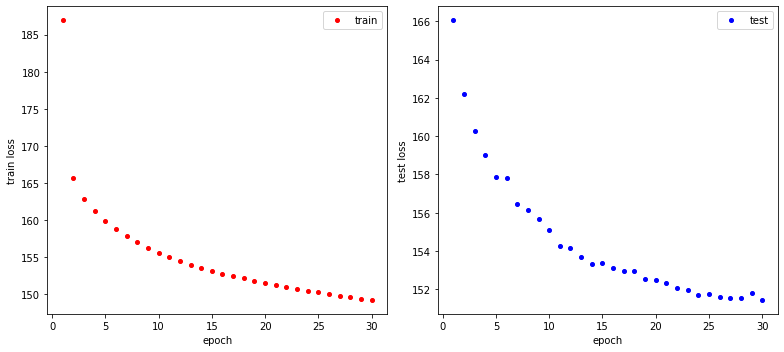

In [7]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(11,5))

ax[0].plot(range(1,len(train_loss_list)+1),train_loss_list,'.r', label='train', markersize=8)
ax[0].set_ylabel('train loss')
ax[0].set_xlabel('epoch')
ax[0].legend()
ax[1].plot(range(1,len(test_loss_list)+1),test_loss_list, '.b',label='test', markersize=8)
ax[1].set_ylabel('test loss')
ax[1].set_xlabel('epoch')
ax[1].legend()
plt.tight_layout()
# plt.savefig('VAE_loss.pdf',format='pdf')

In [8]:
# to save and load model
model_path = 'VAE_MNIST.pth'
torch.save(model.state_dict(), model_path)
model_load=VAE(x_dim=28*28,h1_dim = 500,z_dim=2)
model_load.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [9]:
def reconstruct_img(model,test_loader,n_img):
    model.eval()
    from torchvision.utils import save_image
    with torch.no_grad():
        for imgs, label in test_loader:
            imgs = imgs.to(device)
            save_image(imgs[:n_img], f'original_{list(np.array(label[:n_img]))}.pdf')
            x_prob, mu, log_var = model(imgs[:n_img])
            save_image(x_prob.view(-1,1,28,28),f'reconstructed_{list(np.array(label[:n_img]))}.pdf')
            break

In [10]:
reconstruct_img(model=model,test_loader=test_loader,n_img=10)